In [1]:
import torch
import os
import pandas as pd
import scipy
import torchvision
from torch import optim,nn
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils import StanfordCars, parse_transforms
import yaml
from train_ae import CAE
import config

/homeusers/p63744/software/miniconda3/envs/test_env2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [19]:
import train_ae

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu",0)
print("Device used: ",device)

path = "./defaults.yml"
with open(path, "r") as stream: params = yaml.safe_load(stream)

test_batch = params["test_batch"]
img_size = params["img_size"]
transforms = params["transforms"].split(',')
model_path = params["model_paths"][len(params["model_paths"])-1]
print("Model path = ",model_path)

test_dataset = StanfordCars(root=params["dataset_path"],split ="train",transform=parse_transforms(transforms,img_size))
test_loader = torch.utils.data.DataLoader(  test_dataset, test_batch, shuffle=False, num_workers=4, pin_memory=True)

model = CAE(3,3,img_size,params["latent_dim"])
model.load_state_dict(torch.load(model_path))

def imshowo(img):
    
    img = img.numpy()
   
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

Device used:  cuda:0
Model path =  ./models/CAE 14Sep20h12/model.pth


[tensor(0.7098), tensor(0.7137), tensor(0.7176), tensor(0.7176), tensor(0.7137), tensor(0.6627), tensor(0.5059), tensor(0.5373), tensor(0.5765), tensor(0.5294), tensor(0.4549), tensor(0.2667), tensor(0.2510), tensor(0.5098), tensor(0.3922), tensor(0.3294), tensor(0.1843), tensor(0.2039), tensor(0.2118), tensor(0.1686), tensor(0.2471), tensor(0.3216), tensor(0.3961), tensor(0.2078), tensor(0.1686), tensor(0.2706), tensor(0.3020), tensor(0.3412), tensor(0.3843), tensor(0.7176), tensor(0.6941), tensor(0.6745), tensor(0.6353), tensor(0.6196), tensor(0.6353), tensor(0.6392), tensor(0.6510), tensor(0.6627), tensor(0.6706), tensor(0.5569), tensor(0.6275), tensor(0.4235), tensor(0.3137), tensor(0.4941), tensor(0.5647), tensor(0.5922), tensor(0.6196), tensor(0.6353), tensor(0.5843), tensor(0.4941)]


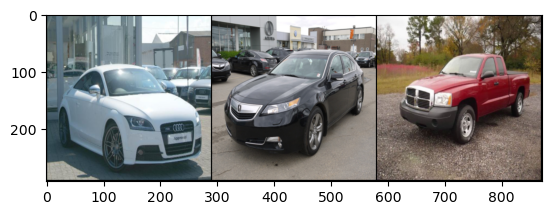

[tensor(0.6715), tensor(0.6719), tensor(0.6707), tensor(0.6709), tensor(0.6704), tensor(0.6705), tensor(0.6689), tensor(0.6686), tensor(0.6668), tensor(0.6659), tensor(0.6611), tensor(0.6590), tensor(0.6514), tensor(0.6501), tensor(0.6446), tensor(0.6419), tensor(0.6330), tensor(0.6332), tensor(0.6317), tensor(0.6306), tensor(0.6269), tensor(0.6269), tensor(0.6249), tensor(0.6234), tensor(0.6187), tensor(0.6195), tensor(0.6194), tensor(0.6188), tensor(0.6167), tensor(0.6173), tensor(0.6168), tensor(0.6158), tensor(0.6129), tensor(0.6148), tensor(0.6178), tensor(0.6184), tensor(0.6205), tensor(0.6224), tensor(0.6256), tensor(0.6261), tensor(0.6273), tensor(0.6288), tensor(0.6307), tensor(0.6309), tensor(0.6314), tensor(0.6326), tensor(0.6340), tensor(0.6339), tensor(0.6334), tensor(0.6355)]


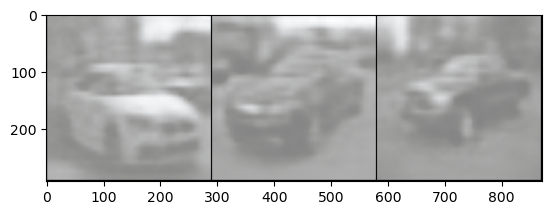

In [58]:
images,_ =  iter(test_loader).next()
nb = 3
images = images[0:nb]

images_grid = torchvision.utils.make_grid(images)

samp = images_grid[1][50][400:450]
print(list(samp))

imshowo(images_grid)

outputs = model(images)
rep = outputs.view(nb,3,img_size,img_size)

rep = torchvision.utils.make_grid(rep)

samp = rep[1][50][400:450]
print(list(samp))

rep -= torch.min(rep)
rep /= torch.max(rep)
rep = torch.nan_to_num(rep)

imshowo(rep)

In [9]:
from tensorboardX import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./results/")

for step in losses:
    writer.add_scalar('Loss/train', step[1], step[0])
    writer.add_scalar('Loss/val', step[2], step[0])

writer.close()

%tensorboard --logdir logs/fit
# https://www.tensorflow.org/tensorboard/get_started

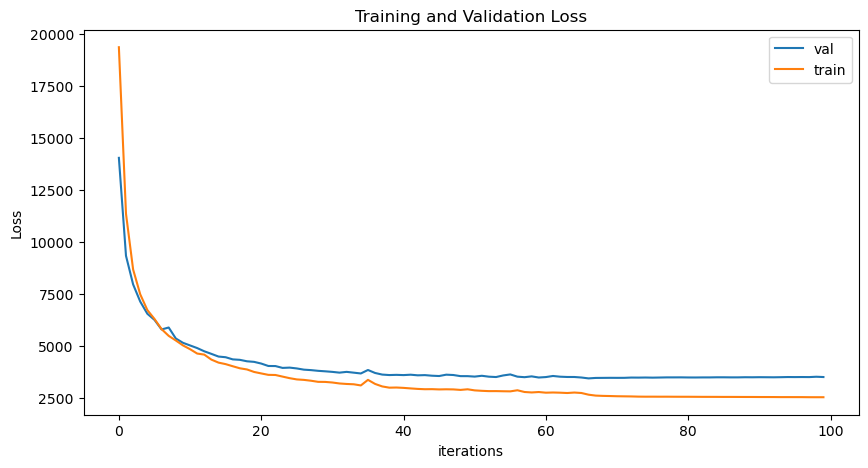

In [13]:
losses = np.array(losses).T
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(losses[2],label="val")
plt.plot(losses[1],label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()